In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
import time
import functools

In [2]:
def load_image(image):
    max_dim = 512
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape*scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    return image

In [3]:
content_image = "content.jpg"
style_image = "style.jpg "

In [4]:
def imshow(image, title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

In [5]:
content_image = load_image(content_image)
style_image = load_image(style_image)
print(content_image.shape,style_image.shape)

(1, 370, 512, 3) (1, 512, 512, 3)


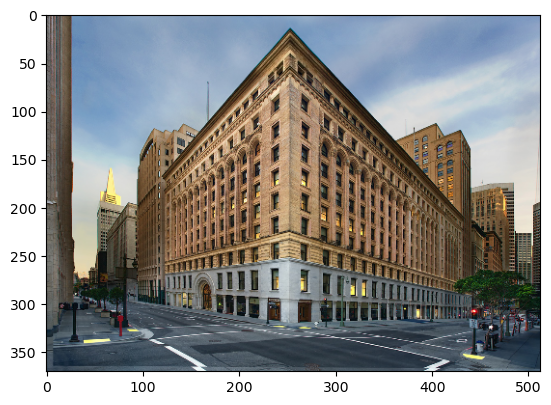

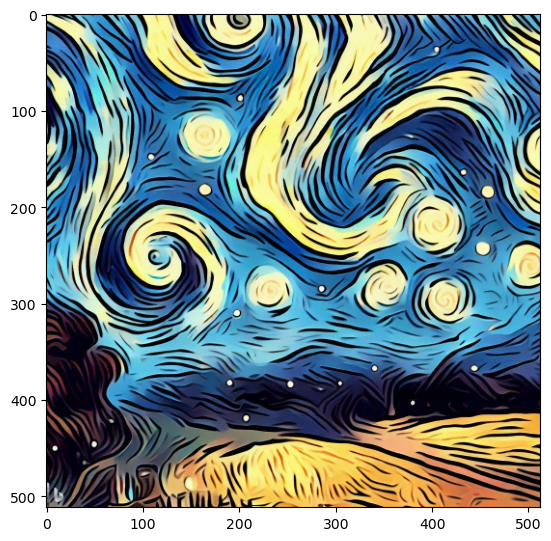

In [6]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
imshow(content_image)
plt.figure(figsize=(14,7))
plt.subplot(1,2,2)
imshow(style_image)

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
x.shape

TensorShape([1, 224, 224, 3])

In [8]:
vgg = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top = False)
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
content_layer=["block5_conv2"]
style_layers =["block1_conv1","block2_conv1",
               "block3_conv1","block4_conv1","block5_conv1"]

num_content_layers = len(content_layer)
num_style_layers = len(style_layers)

In [11]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [13]:
for i in style_outputs:
    print(i.shape)

(1, 512, 512, 64)
(1, 256, 256, 128)
(1, 128, 128, 256)
(1, 64, 64, 512)
(1, 32, 32, 512)


In [14]:
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("shape", output.numpy().shape)
    print()

block1_conv1
shape (1, 512, 512, 64)

block2_conv1
shape (1, 256, 256, 128)

block3_conv1
shape (1, 128, 128, 256)

block4_conv1
shape (1, 64, 64, 512)

block5_conv1
shape (1, 32, 32, 512)



In [15]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("fijc,fijd->fcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [16]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = tf.multiply(inputs, 255.0)
        preprocess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocess_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {style_name:value for style_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {"content": content_dict, "style":style_dict}
                                                                       

In [17]:
extractor = StyleContentModel(style_layers, content_layer)
result = extractor(tf.constant(content_image))

print("styles:")
for name, output in sorted(result["style"].items()):
    print(" ", name)
    print("shape", output.numpy().shape)
    print()

styles:
  block1_conv1
shape (1, 64, 64)

  block2_conv1
shape (1, 128, 128)

  block3_conv1
shape (1, 256, 256)

  block4_conv1
shape (1, 512, 512)

  block5_conv1
shape (1, 512, 512)



In [18]:
for name, output in sorted(result["content"].items()):
    print(" ", name)
    print("shape", output.numpy().shape)
    print()

  block5_conv2
shape (1, 23, 32, 512)



In [19]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [20]:
image = tf.Variable(content_image)

In [21]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [22]:
optim = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

Assigning weight values for style and content loss with after lot of experiments.

In [23]:
style_weight=1e-2
content_weight=1e4

Mathematical expressions for Content loss and Style loss

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    total_loss = style_loss + content_loss
    return total_loss, style_loss, content_loss


In [25]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        total_loss, style_loss, content_loss = style_content_loss(outputs)
    grad = tape.gradient(total_loss, image)
    optim.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return total_loss, style_loss, content_loss


In [26]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor = tensor[0]
    return Image.fromarray(tensor)

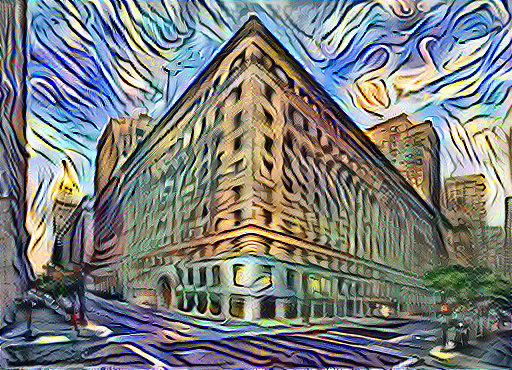

Time taken: 1174.4687700271606 seconds


In [27]:
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

epochs = 10
steps_per_epoch = 100
step = 0

total_loss_list = []
style_loss_list = []
content_loss_list = []

start_time = time.time()
for epoch in range(epochs):
    for steps in range(steps_per_epoch):
        step += 1
        total_loss, style_loss, content_loss = train_step(image)
        
        total_loss_list.append(total_loss.numpy())
        style_loss_list.append(style_loss.numpy())
        content_loss_list.append(content_loss.numpy())
        
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")


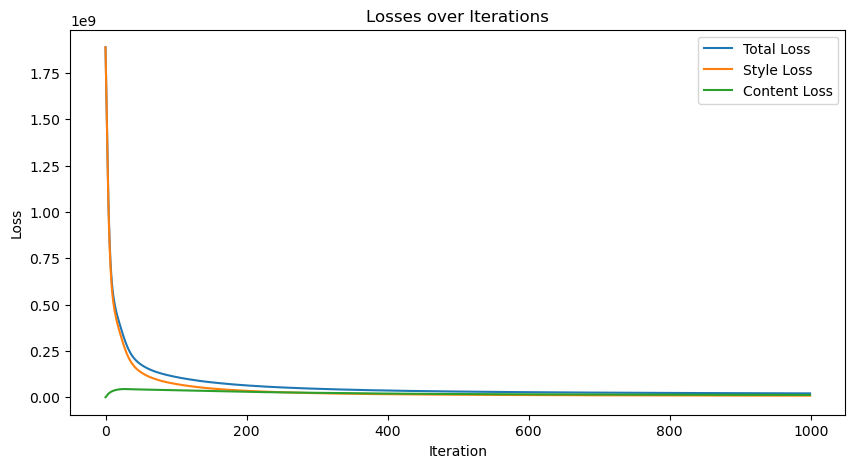

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(total_loss_list, label='Total Loss')
plt.plot(style_loss_list, label='Style Loss')
plt.plot(content_loss_list, label='Content Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses over Iterations')
plt.show()